In [22]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random

from math import sqrt
from numpy import split
from numpy import array
from pandas import read_csv
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from matplotlib import pyplot
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import RepeatVector
from tensorflow.keras.layers import TimeDistributed
from tensorflow.keras.layers import Reshape
from tensorflow import keras

# Przygotowanie danych:

Wczytanie z pliku csv:

In [23]:
df = read_csv('data/data_single_loc.csv')
df

,t2m,d2m,msl,tp,ssrd,Date Time,windspeed_10,windspeed_100
0,262.714033,259.900872,103298.015394,0.000000,0.0,1950-01-01 00:00:00,2.489513,3.817744
1,260.695745,258.184905,103401.866726,0.000000,0.0,1950-01-01 01:00:00,1.837656,3.726080
2,260.195929,257.699157,103434.928307,0.000000,0.0,1950-01-01 02:00:00,2.599009,3.537574
3,259.350219,256.948053,103418.318422,0.000000,0.0,1950-01-01 03:00:00,2.534284,3.147813
4,258.763065,256.665744,103419.030274,0.000000,0.0,1950-01-01 04:00:00,2.623488,3.713367
...,...,...,...,...,...,...,...,...
622387,274.643734,274.172750,100974.912154,0.000006,0.0,2020-12-31 19:00:00,0.809895,1.810642
622388,274.719036,274.144356,100973.148236,0.000005,0.0,2020-12-31 20:00:00,0.868971,1.490224
622389,274.310849,273.971416,100980.668096,0.000003,0.0,2020-12-31 21:00:00,0.774225,1.328229
622390,273.450250,273.092257,100972.962561,0.000002,0.0,2020-12-31 22:00:00,0.649268,0.561700


## Wybór zestawu uczacego i testowego:

In [24]:
train = df[df['Date Time']>='1994-01-01']
train = train[train['Date Time']<'2002-01-01']

test = df[df['Date Time']>='2002-01-01']
test = test[test['Date Time']<'2003-01-01']

## Zamiana daty na sygnał

In [25]:
def datetimeToSignal(df):
    date_time = pd.to_datetime(df.pop('Date Time'), infer_datetime_format=True)

    def datetime_to_seconds(dates):
        return (float)((dates - pd.Timestamp("1970-01-01")) // pd.Timedelta('1s'))

    timestamp_s = date_time.map(datetime_to_seconds)

    day = 24*60*60
    year = (365.2425)*day

    df['Day sin'] = np.sin(timestamp_s * (2 * np.pi / day))
    df['Day cos'] = np.cos(timestamp_s * (2 * np.pi / day))
    df['Year sin'] = np.sin(timestamp_s * (2 * np.pi / year))
    df['Year cos'] = np.cos(timestamp_s * (2 * np.pi / year))
    
    return df

Text(0.5, 1.0, 'Time of day signal')

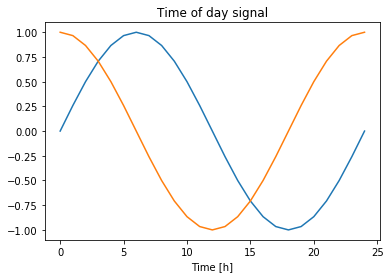

In [26]:
train = datetimeToSignal(train)
test = datetimeToSignal(test)

plt.plot(np.array(train['Day sin'])[:25])
plt.plot(np.array(train['Day cos'])[:25])
plt.xlabel('Time [h]')
plt.title('Time of day signal')

In [27]:
train

,t2m,d2m,msl,tp,ssrd,windspeed_10,windspeed_100,Day sin,Day cos,Year sin,Year cos
385704,276.591343,273.596620,100506.632367,1.932132e-06,0.0,2.114060,5.361759,-1.194924e-12,1.000000,0.003096,0.999995
385705,276.239701,273.369400,100396.343001,4.458765e-07,0.0,2.405930,5.321845,2.588190e-01,0.965926,0.003813,0.999993
385706,276.160200,273.007005,100208.231961,-4.336809e-19,0.0,2.965422,6.456552,5.000000e-01,0.866025,0.004530,0.999990
385707,276.464446,273.140248,100168.421244,-4.336809e-19,0.0,2.014878,4.494060,7.071068e-01,0.707107,0.005247,0.999986
385708,276.756462,273.067511,100306.858875,1.426805e-05,0.0,2.988442,6.387299,8.660254e-01,0.500000,0.005964,0.999982
...,...,...,...,...,...,...,...,...,...,...,...
455827,268.716680,266.967547,102182.755406,3.642718e-04,0.0,4.235441,7.019842,-9.659258e-01,0.258819,0.000545,1.000000
455828,268.546564,266.426877,102303.220947,2.379452e-04,0.0,4.918338,7.976831,-8.660254e-01,0.500000,0.001262,0.999999
455829,268.176845,266.142083,102400.963686,2.041077e-04,0.0,5.307397,8.410755,-7.071068e-01,0.707107,0.001978,0.999998
455830,267.034420,264.758975,102492.461991,1.640441e-04,0.0,5.672091,9.402890,-5.000000e-01,0.866025,0.002695,0.999996


## Normalizacja

In [28]:
values_train = train.values
values_test = test.values

# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaler.fit(values_train)
scaler_y = MinMaxScaler(feature_range=(0, 1))
scaler_y.fit(values_train[:,5].reshape(len(values_train),1))

values_train = scaler.transform(values_train)
values_test = scaler.transform(values_test)

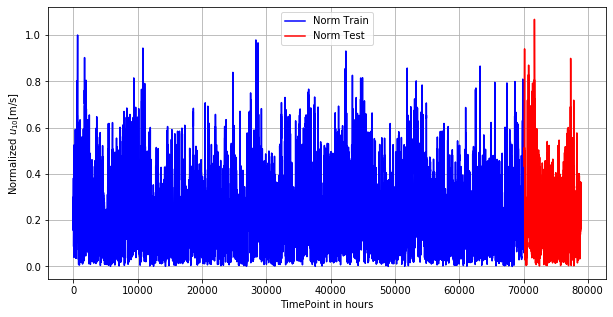

In [29]:
plt.figure(figsize=[10,5])
plt.xlabel('TimePoint in hours')
plt.ylabel('Normalized $u_{10}$[m/s]')
plt.grid()
plt.plot(range(len(values_train)),values_train[:,5],'b')
plt.plot(range(len(values_train),len(values_train)+len(values_test)),values_test[:,5],'r')
plt.legend(['Norm Train','Norm Test']);

## Zmiana szeregu czasowego na input/output

In [30]:
# Multiple steps predicted:

# convert history into inputs and outputs
def to_supervised_multistep(data, n_input, n_out=1):
    X, y = list(), list()
    in_start = 0
    # step over the entire history one time step at a time
    for _ in range(len(data)):
        # define the end of the input sequence
        in_end = in_start + n_input
        out_end = in_end + n_out
        # ensure we have enough data for this instance
        if out_end < len(data):
            X.append(data[in_start:in_end, :])
            y.append(data[in_end:out_end, 5])
        # move along one time step
        in_start += 1
    return array(X), array(y)

# One step predicted:
def to_supervised(data, n_input, n_out=1):
    X, y = list(), list()
    in_start = 0
    # step over the entire history one time step at a time
    for _ in range(len(data)):
        # define the end of the input sequence
        in_end = in_start + n_input
        out_end = in_end + n_out
        # ensure we have enough data for this instance
        if out_end < len(data):
            X.append(data[in_start:in_end, :])
            y.append(data[out_end-1, 5]) # 5 indicates 'windspeed10' parameter
        # move along one time step
        in_start += 1
    return array(X), array(y).reshape((len(y),1))

X_train, y_train = to_supervised_multistep(values_train, n_input=24, n_out=6)
X_test, y_test = to_supervised_multistep(values_test, n_input=24, n_out=6)

In [31]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(70098, 24, 11)
(70098, 6)
(8730, 24, 11)
(8730, 6)


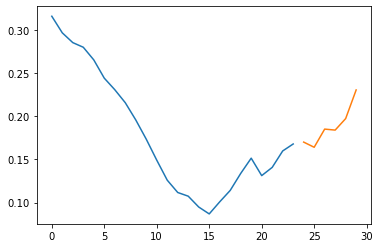

In [32]:
n = random.randrange(len(X_train))
plt.plot(np.arange(24), X_train[n,:,5])
plt.plot(np.arange(24,30), y_train[n,:])

# Stworzenie i trening modeli

In [33]:
def compile_and_fit(model, X_train, y_train):
    early_stopping = keras.callbacks.EarlyStopping(monitor='loss',
                                                   patience=2,
                                                   mode='min')

    model.compile(loss='mean_squared_error',
                  optimizer='adam')

    model.fit(X_train, y_train, epochs=100, batch_size=32, callbacks=[early_stopping])

def evaluate(model, X_test, y_test, display = True):
    # make predictions
    testPredictions = model.predict(X_test)

    # invert scalling
    testPredictions = scaler_y.inverse_transform(testPredictions)
    testYTrue = scaler_y.inverse_transform(y_test)

    # calculate RMSE
    testScore = sqrt(mean_squared_error(testYTrue, testPredictions))
    
    if display:
        print('Test Score: %.4f RMSE' % (testScore))
        length = 168
        start = random.randrange(len(testYTrue)-length)
        end = start+length
        plt.figure(figsize=[10,5])
        plt.xlabel('TimePoint in hours')
        plt.ylabel('$windspeed_{10}[m/s]$')
        plt.grid()
        plt.plot(range(length), testYTrue[start:end,-1],'k.')
        plt.plot(range(length),testPredictions[start:end,-1],'r')
        plt.legend(['Actual','Predicted'])

    return testScore

def cross_corr(model, X_test, y_test):
    # make predictions
    testPredictions = model.predict(X_test)

    # invert scalling
    testPredictions = scaler_y.inverse_transform(testPredictions)
    testYTrue = scaler_y.inverse_transform(y_test)
    testPredictions = testPredictions[:,-1].reshape((testPredictions.shape[0]))
    testYTrue = testYTrue[:,-1].reshape((testYTrue.shape[0]))

    plt.figure(figsize=[10,5])
    plt.xcorr(testYTrue, testPredictions, usevlines=False)
    plt.grid()
    plt.title("Cross correlation between predictions and actual values")


## Dense:

In [34]:
dense = Sequential([
    Dense(units=100, activation='relu', input_shape=(24,11)),
    Dropout(0.2),
    Dense(units=100, activation='relu'),
    Dropout(0.2),
    Dense(units=24, activation='relu'),
    Dense(6),
    Reshape([6,24]),
    Dense(1),
    Reshape([6])
])
dense.summary()
compile_and_fit(dense, X_train, y_train)


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_5 (Dense)              (None, 24, 100)           1200      
_________________________________________________________________
dropout_2 (Dropout)          (None, 24, 100)           0         
_________________________________________________________________
dense_6 (Dense)              (None, 24, 100)           10100     
_________________________________________________________________
dropout_3 (Dropout)          (None, 24, 100)           0         
_________________________________________________________________
dense_7 (Dense)              (None, 24, 24)            2424      
_________________________________________________________________
dense_8 (Dense)              (None, 24, 6)             150       
_________________________________________________________________
reshape_2 (Reshape)          (None, 6, 24)            

Test Score: 1.5018 RMSE


1.5017867580873467

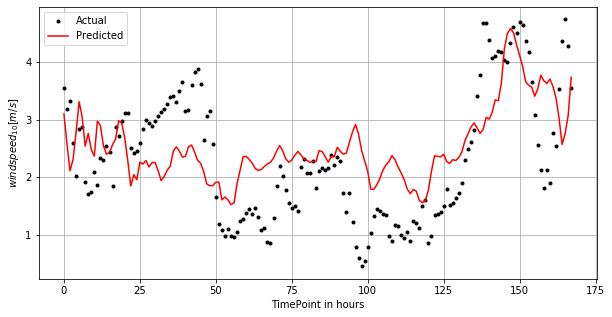

In [35]:
evaluate(dense, X_test, y_test)

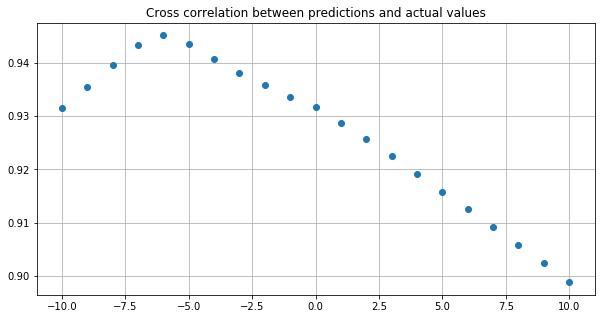

In [36]:
cross_corr(dense, X_test, y_test)

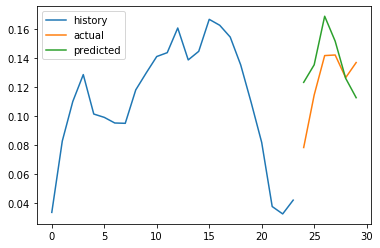

In [40]:
testPredictions = dense.predict(X_test)
n = random.randrange(len(X_test))
plt.plot(np.arange(24), X_test[n,:,5])
plt.plot(np.arange(24,30), y_test[n,:])
plt.plot(np.arange(24,30), testPredictions[n,:])
plt.legend(['history','actual','predicted'])

In [38]:
y_test.shape

(8730, 6)

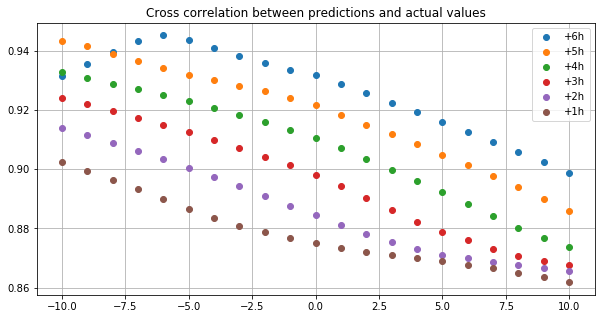

In [39]:
def cross_corr_multistep(model, X_test, y_test):
    # make predictions
    testPredictions = model.predict(X_test)

    # invert scalling
    testPredictions = scaler_y.inverse_transform(testPredictions)
    testYTrue = scaler_y.inverse_transform(y_test)

    plt.figure(figsize=[10,5])
    plt.grid()
    plt.title("Cross correlation between predictions and actual values")
    n = y_test.shape[1]
    labels = []
    for i in range(1,n+1):  
        testPredictionsPlot = testPredictions[:,-i].reshape((testPredictions.shape[0]))
        testYTruePlot = testYTrue[:,-1].reshape((testYTrue.shape[0]))
        plt.xcorr(testYTruePlot, testPredictionsPlot, usevlines=False)
        labels.append("+{}h".format(7-i))
    plt.legend(labels)

cross_corr_multistep(dense, X_test, y_test)